In [3]:

import os
import pandas as pd
import numpy as np
#import pgmpy
from sklearn.model_selection import train_test_split
from ucimlr import classification_datasets, regression_datasets
from catboost import CatBoostClassifier, Pool, cv
import matplotlib.pyplot as plt
import seaborn as sns

!jupyter nbextension enable --py widgetsnbextension

#classification_datasets.BankMarketing('../data/')  --- stores Bank marketing dataset in local folder

df = pd.read_csv('../data/BankMarketing/bank-additional/bank-additional-full.csv', sep=';')

df.head()

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
# we should drop call duration as it has 1-1 relationship with target

df = df.drop('duration', axis=1)

In [5]:
y_col = 'y'
x_cols = df.columns.drop('y') 
# run catboost algo to pull out most important features to use as nodes in network
y = df['y']
x = df.drop('y', axis=1)
x_train, x_test, y_train, y_test = train_test_split(x.values, y.values, test_size=0.2, shuffle=True, random_state=42)


# parameters for training inside cv:
params = {
    'loss_function': 'Logloss',
    'iterations': 40,
    'depth':3,
    'custom_loss': 'AUC',
    'learning_rate': 0.3,
}

    
def print_cv_summary(cv_data,train_pool, **params):
    
    cv_data = cv(
        params = params,
        pool = train_pool,
        fold_count=5,
        shuffle=True,
        partition_random_seed=0,
        stratified=True,
         plot=True,
        verbose=False
    )

    best_value = cv_data['test-Logloss-mean'].min()
    best_iter = cv_data['test-Logloss-mean'].values.argmin()

    print('Best validation Logloss score : {:.4f}±{:.4f} on step {}'.format(
        best_value,
        cv_data['test-Logloss-std'][best_iter],
        best_iter)
    )
    
    return cv_data

    

train_data = Pool(x_train, y_train, cat_features=[1,2,3, 4, 5, 6, 7, 8, 9, 13])
test_data = Pool(x_test, y_test, cat_features=[1,2,3, 4, 5, 6, 7, 8, 9, 13])


model = CatBoostClassifier(**params)
# train the model
model.fit(train_data, eval_set=test_data, plot=True)



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5208038	test: 0.5222006	best: 0.5222006 (0)	total: 61ms	remaining: 2.38s
1:	learn: 0.4271310	test: 0.4296791	best: 0.4296791 (1)	total: 67.6ms	remaining: 1.28s
2:	learn: 0.3708345	test: 0.3745984	best: 0.3745984 (2)	total: 74.5ms	remaining: 918ms
3:	learn: 0.3364321	test: 0.3411154	best: 0.3411154 (3)	total: 90.7ms	remaining: 816ms
4:	learn: 0.3153913	test: 0.3209046	best: 0.3209046 (4)	total: 96.4ms	remaining: 675ms
5:	learn: 0.3010090	test: 0.3072734	best: 0.3072734 (5)	total: 102ms	remaining: 575ms
6:	learn: 0.2925560	test: 0.2993190	best: 0.2993190 (6)	total: 107ms	remaining: 504ms
7:	learn: 0.2884086	test: 0.2953544	best: 0.2953544 (7)	total: 112ms	remaining: 449ms
8:	learn: 0.2844322	test: 0.2919747	best: 0.2919747 (8)	total: 118ms	remaining: 406ms
9:	learn: 0.2818363	test: 0.2896886	best: 0.2896886 (9)	total: 126ms	remaining: 378ms
10:	learn: 0.2798828	test: 0.2880628	best: 0.2880628 (10)	total: 140ms	remaining: 368ms
11:	learn: 0.2776868	test: 0.2866104	best: 0.2866

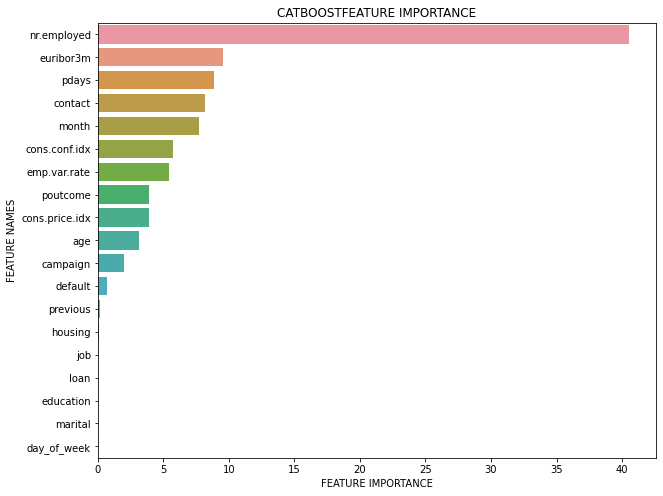

In [6]:

def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    
    return fi_df
    
#plot the catboost result
fi_df = plot_feature_importance(model.get_feature_importance(train_data),x_cols,'CATBOOST')

In [23]:
#Lets take 15 features from the chart above: and accessible from fi_df


top_features = fi_df.head(15)['feature_names'].values
top_features_target = list(top_features) + ['y']
top_features_target

['nr.employed',
 'euribor3m',
 'pdays',
 'contact',
 'month',
 'cons.conf.idx',
 'emp.var.rate',
 'poutcome',
 'cons.price.idx',
 'age',
 'campaign',
 'default',
 'previous',
 'housing',
 'job',
 'y']

In [24]:
df_network = df.loc[:, top_features_target]

[bnlearn] >Bayesian DAG created.
[bnlearn] >Plot based on BayesianModel


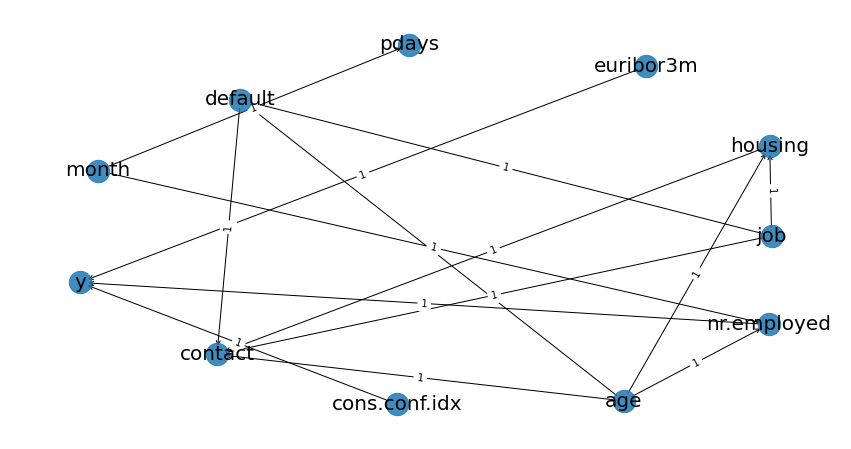

{'pos': {'age': array([ 0.44261128, -0.92247383]),
  'nr.employed': array([ 0.82677044, -0.5100915 ]),
  'contact': array([-0.63421477, -0.6718238 ]),
  'job': array([ 0.83469629, -0.03176976]),
  'month': array([-0.94994147,  0.32009281]),
  'y': array([-0.99747046, -0.28337331]),
  'euribor3m': array([0.5021907 , 0.88224215]),
  'cons.conf.idx': array([-0.15748096, -0.93964345]),
  'pdays': array([-0.12467418,  1.        ]),
  'default': array([-0.57230469,  0.70331944]),
  'housing': array([0.82981779, 0.45352126])},
 'G': <networkx.classes.digraph.DiGraph at 0x7fb7d0f9f5b0>}

In [122]:

edges = [('age', 'nr.employed'), 
         ('age', 'contact'), 
         ('job', 'contact'), 
         ('month', 'nr.employed'), 
         ('nr.employed', 'y'),
         ('euribor3m','y'),
         ('cons.conf.idx','y'),
         ('month', 'pdays'),
         ('age', 'default'), 
         ('job', 'default'),
         ('job', 'housing'),
         ('default', 'contact'), 
         ('age', 'housing'), 
         ('housing', 'contact')]



# Create the DAG from the edges
DAG = bnlearn.make_DAG(edges)

# Plot and make sure the arrows are correct.
bnlearn.plot(DAG)


[bnlearn] >Warning: Computing DAG with 11 nodes can take a very long time!
[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Plot based on BayesianModel


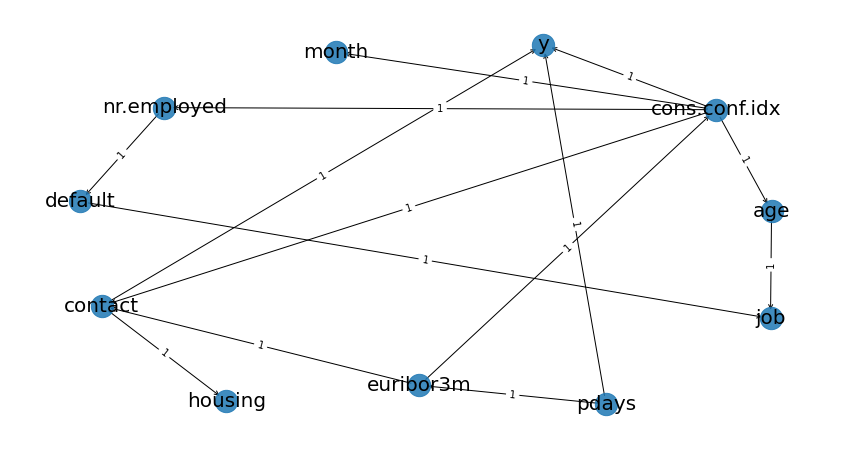

{'pos': {'nr.employed': array([-0.73488593,  0.66229118]),
  'euribor3m': array([-0.03035366, -0.8276559 ]),
  'cons.conf.idx': array([0.78810421, 0.6510427 ]),
  'month': array([-0.26172231,  0.96019298]),
  'pdays': array([ 0.48458773, -0.92831268]),
  'contact': array([-0.90695711, -0.40135191]),
  'age': array([0.94169755, 0.10536414]),
  'default': array([-0.96781686,  0.15851617]),
  'job': array([ 0.93877901, -0.46862694]),
  'housing': array([-0.5634915 , -0.91145975]),
  'y': array([0.31205887, 1.        ])},
 'G': <networkx.classes.digraph.DiGraph at 0x7fb7d0f9fa30>}

In [155]:
# Structure learning on the data set
model = bnlearn.structure_learning.fit(df_network)
# Plot the DAG
bnlearn.plot(model)


In [149]:
DAG_update = bnlearn.parameter_learning.fit(model, df_network)

[BNLEARN][PARAMETER LEARNING] Computing parameters using [bayes]
[bnlearn] >Conversion of adjmat to BayesianModel.
CPD of nr.employed:
+---------------------+----------------------+----------------------+----------------------+----------------------+-----------------------+----------------------+-----------------------+-----------------------+-----------------------+-----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+-----------------------+-----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+
| cons.conf.idx       | cons.conf.idx(-50.8) | cons.conf.idx(-50.0) | cons.conf.idx(-49.5) | cons.conf.idx(-47.1) | cons.conf.idx(-46.2)  | cons.conf.idx(-45.9) | cons.conf.idx(-42.7)  | cons.conf.idx(-42.0)  | cons.conf.idx(-41.8)  | c

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [124]:
# Generate samples
bnlearn.sampling(DAG, n=1000)

Generating for node: default:  64%|██████▎   | 7/11 [00:00<00:00, 54.08it/s]

[bnlearn] >Forward sampling for 1000 samples..


Generating for node: y: 100%|██████████| 11/11 [00:32<00:00,  2.97s/it]         


,cons.conf.idx,euribor3m,month,pdays,job,age,housing,default,contact,nr.employed,y
0,-41.8,4.967,may,999,management,35,no,no,cellular,5191.0,no
1,-46.2,1.483,may,999,blue-collar,21,yes,no,cellular,5099.1,yes
2,-47.1,4.858,aug,999,technician,27,no,no,cellular,5076.2,no
3,-36.4,1.281,may,999,entrepreneur,32,no,no,telephone,5099.1,no
4,-36.4,4.963,jun,999,admin.,36,no,no,telephone,5228.1,no
...,...,...,...,...,...,...,...,...,...,...,...
995,-36.1,1.250,may,999,management,32,no,no,telephone,5099.1,no
996,-46.2,1.327,jun,999,blue-collar,71,no,yes,cellular,4963.6,yes
997,-41.8,4.965,jun,999,entrepreneur,41,yes,no,telephone,5228.1,yes
998,-42.0,1.327,apr,6,admin.,42,yes,no,cellular,5099.1,yes


In [178]:
bnlearn.inference.fit(DAG_update, variables=['y'], evidence={'age':21})

Eliminating: cons.conf.idx: 100%|██████████| 9/9 [00:00<00:00, 217.47it/s]

[bnlearn] >Variable Elimination..
+--------+----------+
| y      |   phi(y) |
+========+==========+
| y(no)  |   0.7125 |
+--------+----------+
| y(yes) |   0.2875 |
+--------+----------+


<DiscreteFactor representing phi(y:2) at 0x7fb7d1405a90>

#### try pomegranate library

In [37]:
from pomegranate import *
import numpy as np



bnet = BayesianNetwork.from_samples(df_network[0:2000])
bnet.fit(df_network[0:2000].values)

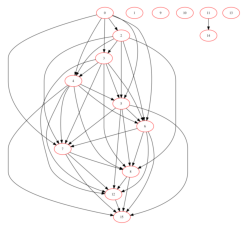

In [49]:
bnet.plot()

In [79]:

X = np.random.random(size=(5,5))

model = HiddenMarkovModel.from_samples(NormalDistribution, n_components=5, X=X)
y = np.random.random(size=(1,6))
model_update = model.fit(sequences=y, algorithm='baum-welch')

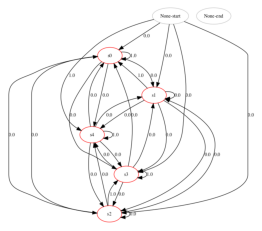

In [80]:
model_update.plot(0)